In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

#arbitrarily choose images/cameras
chosenImages = [4,5,6,7,8,9,10]
numChosen = len(chosenImages)

# initialize filepaths
## later implement input for directory
cDIR = os.getcwd()
NDPath = cDIR + r'\NotreDame\NotreDame'
listFile = NDPath + '\list.txt'
outFile = NDPath + r'\notredame.out'

In [3]:
### Extract the camera parameters and point correspondences from the output file, `notredame.out`, from Bundler
try:
    with open(outFile) as fp:
        line0 = fp.readline() #read line 0 (the title)
        num_cameras, num_points = map(int, fp.readline().strip('\n').split(' ')) #read line 1

        camera_data = np.array([], dtype = float)
        points_3d = np.empty([num_points,3], dtype = float)
        points_3d_rgb = np.empty([num_points,3], dtype = int)
    #     view_list = np.empty(num_points, dtype = float)
        camera_index = np.array([], dtype = int)
        point_index = np.array([], dtype = int)
        xp = np.array([], dtype = float)
        yp = np.array([], dtype = float)
        total_num_views = 0

        # extract camera parameters, starts reading on line 2
        for i in range(num_cameras):
            c = 5
            if len(camera_data) == 0:
                camera_data = np.array(fp.readline().strip('\n').split(' '),dtype = float)
                c = 4
            for j in range(c):
                camera_data = np.vstack([camera_data,np.array(fp.readline().strip('\n').split(' '),dtype = float)]) #reads 5 lines         

        # extract point correspondences of outputted 3D points, starts reading on line 2+num_cameras*5
        for i in range(num_points):
            points_3d[i] = np.array(fp.readline().strip('\n').split(' '),dtype = float) #read 3D coordinates
            points_3d_rgb[i] = np.array(fp.readline().strip('\n').split(' '),dtype = int) #read RGB value
            line = np.array(fp.readline().strip('\n').split(' '),dtype = float) #read view list
            num_views = int(line[0])
            for j in range(num_views):
                cameraID = int(line[j*4+1])
    #             num_views_per_point = 0
                if chosenImages.count(cameraID) == 1: #does camera match chosen images?
    #                 num_views_per_point += 1
                    x = line[j*4+3]
                    y = line[j*4+4]
                    camera_index = np.append(camera_index,cameraID)
                    point_index = np.append(point_index,i)
                    xp = np.append(xp,x)
                    yp = np.append(yp,y)
                    total_num_views += 1
except:
    print('Data parsing unsuccessful. Check data file format')

if ((len(camera_index)==len(point_index)) and (len(point_index) == len(xp)) 
    and (len(xp)==len(yp)) and (len(yp)==total_num_views)):
    print('Data parsing successful')
else:
    print('Data parsing unsuccessful. Check data file format')

               
# for i in range(num_cameras):
#     camera = Camera()
#     camera.f = camera_data[i*5,0]
#     camera.k1 = camera_data[i*5,1]
#     camera.k2 = camera_data[i*5,2]
#     camera.R = camera_data[i*5+1:i*5+4] #
#     camera.t = camera_data[i*5+4]
#     cameras.append(camera)

Data parsing successful


In [21]:
print('total_num_views:',total_num_views)
unique_points = list(set(point_index))
print('num_unique_points:',len(unique_points))
unique_cameras = list(set(camera_index))
print('num_uniqe_cameras:',len(unique_cameras))
unique_points = points_3d[list(set(point_index))]


total_num_views: 4755
num_unique_points: 4066
num_uniqe_cameras: 7
point index 0:  1
point index 1:  1
point index 2:  2
point index 3:  2
point 0: [ 0.09059939 -0.02897864 -1.37835874]
point 1: [ 0.41990737  0.03282281 -1.36521187]
point 2: [-0.02590478  0.24351764 -1.53708274]
unique point 1: [ 0.41990737  0.03282281 -1.36521187]
unique point 2: [-0.02590478  0.24351764 -1.53708274]


In [35]:
### Define functions

def project(point, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    
    # allocate camera parameters
    R = camera_params[1:4,:]
    t = camera_params[4]
    f,k1,k2 = camera_params[0]
    
    Q = np.matmul(R,np.transpose(point)) + np.transpose(t) #convert real world to camera coordinates
    q = -Q[0:1]/Q[2] #perspective division
    q2 = np.linalg.norm(q)
    p = f*(1+k1*q2+k2*q2*q2)*q #convert to pixel coordinates
    
    return p

def batch_project(points_3d, point_index, camera_data, camera_index, total_num_views):
    point_proj = np.empty([total_num_views,2])
    for i in range(total_num_views):
        point_proj[i] = project(points_3d[point_index[i]],
                                                   camera_data[camera_index[i]*5:camera_index[i]*5+5,:])
    
    return point_proj

def collect_unique(points_3d, point_index, camera_data, camera_index, chosenImages):
    """ Collect only those cameras and 3D points from the full dataset that appear in the chosen image set"""
    unique_points = points_3d[list(set(point_index))]
    
    
def fun(camera_params, camera_index, point_index, points_3d, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    points_proj = batch_project(points_3d, point_index, camera_data, camera_index, total_num_views)
    
    return (points_proj - points_2d).ravel()

from scipy.sparse import lil_matrix

def sparseJacobian(chosenImages, total_num_views):
    m = total_num_views * 2
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

    return A

NameError: name 'least_squares' is not defined

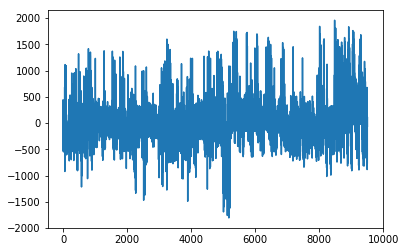

In [45]:
residuals = fun(camera_data, camera_index, point_index, points_3d, np.transpose([xp,yp]))
plt.plot(residuals)

### Optimize (least squares)
import time
from scipy.optimize import least_squares
t0 = time.time()
res = least_squares(fun, points_3d.ravel(), jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(camera_data, camera_index, point_index, points_3d, np.transpose([xp,yp])))
t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))